In [1]:
import matplotlib 
import numpy as np
from scipy.stats import logistic
from scipy.optimize import basinhopping
from scipy import interpolate
from IPython.display import clear_output, Javascript, Markdown
import matplotlib.colors as colors
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import scipy.io
import gc
import datetime
import time
import mat73
import hdf5storage
import random
import matplotlib
import _spin_params as spin_pars
from _create_pdf import create_spins, create_spins_inhomo_g
from _helper_functions import tsallis, cauchy, find_nearest, odeintz, find_nearest_sorted_left, find_nearest_sorted
from _steady_state import a_steady, a_steady_with_sz, sz_steady, sz_steady_from_a
from _mbes import mbes, mbes_soc
from _do_calculation import solve_mbes, solve_mbes_without_cavity, get_pulses_from_cavity_field, solve_mbes_wait, solve_mbes_only_decay
#matplotlib.pyplot.switch_backend('nbagg')
#%qtconsole

In [2]:
gcoll = spin_pars.gcoll
q = spin_pars.q
quali = spin_pars.quali
fr = spin_pars.fr;
kappa = np.pi*fr/quali #HWHM
delta = spin_pars.delta #detuning cavity to spin central frequency ws-wc
deltac = spin_pars.deltac #detuning drive to cavity wc-wp
gperp = spin_pars.gperp #HWHM
gpar = spin_pars.gpar#0.001 #HWHM
gammaq = spin_pars.gammaq
nbins = spin_pars.nbins#701#5000#20
nbins = 301
g_number = spin_pars.g_number #how many bins for inhomogeneous coupling
#g0 = gcoll/sqrt(nspins)
print(kappa)


0.37689445404143396


In [3]:
def pulse_rwa(t, args):
    wgrund = args[0]
    fcomps = args[1]
    pulse = 0
    for i in range(len(fcomps)):
        pulse = pulse+(fcomps[i])*np.sin((i+1)*wgrund*t)
    return pulse

def pulse_rwa_gauss(t, args):
    wgrund = args[0]
    fcomps = args[1]
    nfcomps = len(fcomps)
    tend = np.pi/wgrund
    
    width = 2*tend/(nfcomps+5)
    t0 = 3*width/2
    pulse = 0
    for i in range(len(fcomps)):
        pulse += fcomps[i]*np.exp(-4*(t-t0)**2*np.log(2)/width**2)
        t0 += 0.5*width
    pulse *= logistic.cdf(t, loc=0.01, scale=.002)*(1-logistic.cdf(t, loc=tend-0.01, scale=.002))
    pulse *= 0.46971947398573455
    return pulse

def pulse_rwa_gauss_const(t, args):
    wgrund = args[0]
    fcomps = args[1]
    maxampl = args[2]
    nfcomps = len(fcomps)
    tend = np.pi/wgrund

    #xint = np.linspace(0, tend, nfcomps)
    
    #spline = interpolate.BSpline(xint, fcomps, 2)
    spline = 0
    for i in range(len(fcomps)):
        spline += (fcomps[i])*np.sin((i+1)*wgrund*t)

    #spline = spline/nfcomps
    pulsei = 0
    pulseq = 0
    pulse = 0
    pulse = maxampl*logistic.cdf(t, loc=0.02, scale=0.004)*(1-logistic.cdf(t, loc=tend-0.02, scale=0.004))
    
    pulsei = pulse*np.cos(spline)
    pulseq = pulse*np.sin(spline)

    return pulsei, pulseq


In [4]:
def g_inhomo_function(x, sigma):
    return np.exp(-x**2/sigma**2)

x_start = 5
x_stop = 20 #µm
x = np.linspace(x_start, x_stop, g_number)
sigma = 5
g_temp = g_inhomo_function(x, sigma)
g_list = g_temp/np.sum(g_temp)

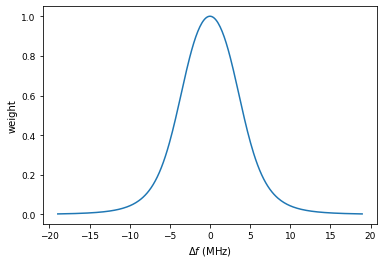

In [5]:
spins, gs, pdf = create_spins_inhomo_g(gcoll, g_list, q, delta, gammaq, nbins, holes=False, inhomo=True, hyperfine=True)
plt.figure()
plt.plot(spins[:len(pdf)], pdf/max(pdf))
plt.xlabel('$\Delta f$ (MHz)')
plt.ylabel('weight');
#%qtconsole

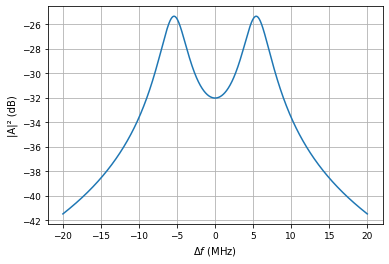

In [6]:
initsteady = (0.001,0.001)
fstart = 20
deltaarr = np.linspace(-fstart*2*np.pi,fstart*2*np.pi, 2000)
etasteady = 0.00001
losasteady = np.zeros(np.shape(deltaarr))
losareal = np.zeros(np.shape(deltaarr))
losaimag = np.zeros(np.shape(deltaarr))
gs_copl = gs[:len(pdf)]/np.linalg.norm(gs[:len(pdf)])*gcoll
newinit = initsteady
for i, delt in enumerate(deltaarr):
    ar, ai = a_steady(etasteady, delt, gs_copl, spins[:len(pdf)], gpar, gperp, kappa, newinit)
    newinit = (ar, ai)
    losasteady[i] = ai**2+ar**2
    losareal[i] = ar
    losaimag[i] = ai

fig = plt.figure()
plt.xlabel('$\Delta f$ (MHz)')
plt.ylabel('|A|² (dB)');
plt.plot(deltaarr/2/np.pi, 10*np.log10(losasteady/0.0000000001))
#deltaarr[find(losasteady == max(losasteady))]/2/pi
plt.grid(True)

### Calculate dispersive shift for offresonant driving in steady state

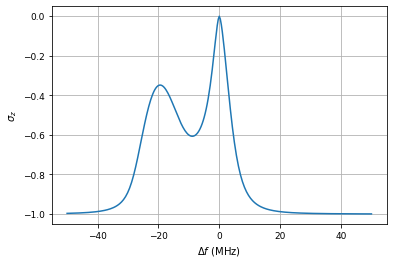

In [125]:
fstart = -50
fstop = 50
detuning_spins = -20


deltaarr_spins = np.linspace(fstart*2*np.pi,fstop*2*np.pi, 303)
etasteady = 8
losszsteady = np.zeros((len(deltaarr_spins), nbins))
gs_copl = gs[:len(pdf)]/np.linalg.norm(gs[:len(pdf)])*gcoll
newinit = (np.sqrt(etasteady),)*2
for i, delt in enumerate(deltaarr_spins):
    sz = sz_steady_from_a(etasteady, delt, gs_copl, spins[:len(pdf)]-detuning_spins, gpar, gperp, kappa, newinit, pdf)
    #newinit = sz.copy()
    losszsteady[i, :] = sz


fig = plt.figure()
plt.xlabel('$\Delta f$ (MHz)')
plt.ylabel('$\sigma_z$');
plt.plot(deltaarr_spins/2/np.pi, np.sum(losszsteady, axis=1))
#deltaarr[find(losasteady == max(losasteady))]/2/pi
plt.grid(True)

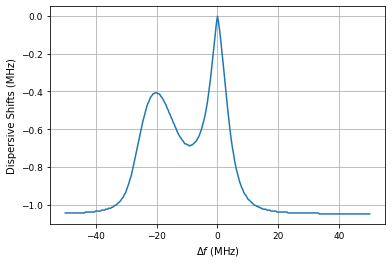

In [126]:
initsteady = (0.001,0.001)
fstart = 5
deltaarr = np.linspace(-fstart*2*np.pi,fstart*2*np.pi, 2000)
etasteady = 0.00001
losasteady_shift = np.zeros((len(deltaarr_spins), len(deltaarr)))
losareal_shift = np.zeros(losasteady_shift.shape)
losaimag_shift = np.zeros(losasteady_shift.shape)
freqshifts = np.zeros((len(deltaarr_spins)))
newinit = initsteady
for j, szsteady in enumerate(losszsteady):
    for i, delt in enumerate(deltaarr):
        ar, ai = a_steady_with_sz(etasteady, delt, gs_copl, spins[:len(pdf)]+detuning_spins, gpar, gperp, kappa, szsteady/pdf)
        newinit = (ar, ai)
        losasteady_shift[j, i] = ai**2+ar**2
        losareal_shift[j, i] = ar
        losaimag_shift[j, i] = ai
    idx = np.where(losasteady_shift[j,:]== np.max(losasteady_shift[j,:]))
    freqshifts[j] = deltaarr[idx]/2/np.pi

fig = plt.figure()
plt.xlabel('$\Delta f$ (MHz)')
plt.ylabel('Dispersive Shifts (MHz)');
plt.plot(deltaarr_spins/2/np.pi, freqshifts)
#deltaarr[find(losasteady == max(losasteady))]/2/pi
plt.grid(True)